**SNN-crafted Grad-CAM, SAM and SNN ScoreCAM**  

In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d

from RISE_utils import *
from evaluation import CausalMetric, auc, gkern


cudnn.benchmark = True

import argparse
import numpy as np
import os.path
import matplotlib.gridspec as gridspec
import skimage.transform
import matplotlib.pyplot as plt
from utils import *
from   torch.utils.data.dataloader import DataLoader
from   torchvision import transforms, datasets
from   model import *

model_parameter_path = 'pretrained_tiny_t30.pth.tar' 
dataset_path = 'tiny-imagenet-200/val' 


global args
#args = parser.parse_args()

save_model_path = model_parameter_path 
save_model_statedict = torch.load(save_model_path)['state_dict']
save_model_accuracy = torch.load(save_model_path)['accuracy1']

# select number of samples for visualization
img_nums = [0]

gamma = 0.5
num_timestep = 30
num_workers = 1
batch_size = 1
visual_imagesize = 256#128
target_layer = 8

# Normalization function
class normalize(object):
    def __init__(self, mean, absmax):
        self.mean = mean
        self.absmax = absmax
    def __call__(self, tensor):
        for t, m, am in zip(tensor, self.mean, self.absmax):
            t.sub_(m).div_(am)
        return tensor


# Mean and SD are calculuated
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

valdir = os.path.join(dataset_path)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

testloader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers)


display_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize((visual_imagesize, visual_imagesize)),
            transforms.ToTensor(),
        ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers)

criterion = nn.CrossEntropyLoss()

In [ ]:
"""
    Overall code flow is from Rathi et al. (2020) [https://github.com/nitin-rathi/hybrid-snn-conversion]
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from torch.autograd import Variable
import copy


# --------------------------------------------------
# Spiking neuron with piecewise-linear surrogate gradient
# --------------------------------------------------
class LinearSpike(torch.autograd.Function):
    gamma = 0.3  # Controls the dampening of the piecewise-linear surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input).cuda()
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input * LinearSpike.gamma * F.threshold(1.0 - torch.abs(input), 0, 0)
        return grad


# --------------------------------------------------
# Spiking neuron with pass-through surrogate gradient
# --------------------------------------------------
class PassThruSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        out = torch.zeros_like(input).cuda()
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input


# Overwrite the naive spike function by differentiable spiking nonlinearity which implements a surrogate gradient
def init_spike_fn(grad_type):
    if (grad_type == 'Linear'):
        spike_fn = LinearSpike.apply
    elif (grad_type == 'PassThru'):
        spike_fn = PassThruSpike.apply
    else:
        sys.exit("Unknown gradient type '{}'".format(grad_type))
    return spike_fn


def PoissonGen(inp, rescale_fac=2.0):
    
    rand_inp = torch.rand_like(inp).cuda()
    return torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp))




class SNN_VGG11_forGradCAM(nn.Module):
    def __init__(self, num_timestep=30, leak_mem=0.99):
        super(SNN_VGG11_forGradCAM, self).__init__()

        self.img_size = 64
        self.num_steps = num_timestep
        self.leak_mem = leak_mem
        self.batch_num = self.num_steps

        affine_flag = True
        bias_flag = False

        # Instantiate the ConvSNN layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn1_list = nn.ModuleList([nn.BatchNorm2d(64, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn2_list = nn.ModuleList([nn.BatchNorm2d(128, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn3_list = nn.ModuleList([nn.BatchNorm2d(256, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn4_list = nn.ModuleList([nn.BatchNorm2d(256, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool3 = nn.AvgPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn5_list = nn.ModuleList([nn.BatchNorm2d(512, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn6_list = nn.ModuleList([nn.BatchNorm2d(512, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool4 = nn.AvgPool2d(kernel_size=2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn7_list = nn.ModuleList([nn.BatchNorm2d(512, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=bias_flag)
        self.bn8_list = nn.ModuleList([nn.BatchNorm2d(512, eps=1e-4, momentum=0.1, affine=affine_flag) for i in range(self.batch_num)])
        self.pool5 = nn.AvgPool2d(kernel_size=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(512, 4096, bias=bias_flag)
        self.bnfc_list = nn.ModuleList(
            [nn.BatchNorm1d(4096, eps=1e-4, momentum=0.1, affine=affine_flag) for i in
             range(self.batch_num)])
        self.fc2 = nn.Linear(4096, 200, bias=bias_flag)

        batchnormlist = [self.bn1_list, self.bn2_list, self.bn3_list, self.bn4_list, self.bn5_list,
                         self.bn6_list, self.bn7_list, self.bn8_list, self.bnfc_list]

        for bnlist in batchnormlist:
            for bnbn in bnlist:
                bnbn.bias = None

            # Initialize the firing thresholds of all the layers
        for m in self.modules():
            if (isinstance(m, nn.Conv2d)):
                m.threshold = 1.0
            elif (isinstance(m, nn.Linear)):
                m.threshold = 1.0

        self.saved_forward= []
        
 

        # Instantiate differentiable spiking nonlinearity
        self.spike_fn = init_spike_fn('Linear')
        self.spike_pool = init_spike_fn('PassThru')
        
        ####################################
        # placeholder for internal information
        self.gradients = []
        self.activations = []
        self.hook_dict ={}
        self.hook_dict_2 = {}
        self.fc2_outputs = []

        self.spike_inputs_placeholder = []

        self.rand_inps = [torch.rand([3, 64, 64]).float().cuda() for t in range(self.num_steps) ]
        


    def PoissonGenDeterministic(self,inp, rescale_fac=2.0):
        inp_spikes = []
        b, c, w, h = inp.shape
        for t in range(self.num_steps):
            rand_inp = self.rand_inps[t]
            rand_inp = rand_inp.unsqueeze(0).repeat(b, 1, 1, 1)
            inp_spikes.append(torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp)))    
      
        return inp_spikes

    # hook for the gradients of the activations
    def activations_hook(self, index):
        
        def hook(output):
              
            self.hook_dict_2[index] = output.detach().clone() 
            self.gradients.append(output.detach().clone())
        return hook
    


    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.activations  

 

    def forward(self, inp, target_layer=2,keep=False):
  
        outputList = []
      
        batch_size = inp.size(0)
        h, w = inp.size(2) ,inp.size(3)

        mem_conv1 = Variable(torch.zeros(batch_size, 64, h, w), requires_grad=True).cuda()
        mem_conv2 = Variable(torch.zeros(batch_size, 128, h//2, w//2).cuda(), requires_grad=True)
        mem_conv3 = Variable(torch.zeros(batch_size, 256, h//4, w//4).cuda(), requires_grad=True)
        mem_conv4 = Variable(torch.zeros(batch_size, 256, h//4, w//4).cuda(), requires_grad=True)
        mem_conv5 = Variable(torch.zeros(batch_size, 512, h//8, w//8).cuda(), requires_grad=True)
        mem_conv6 = Variable(torch.zeros(batch_size, 512, h//8, w//8).cuda(), requires_grad=True)
        mem_conv7 = Variable(torch.zeros(batch_size, 512, h // 16, w// 16).cuda(), requires_grad=True)
        mem_conv8 = Variable(torch.zeros(batch_size, 512, h// 16, w// 16).cuda(), requires_grad=True)

        mem_fc1 = torch.zeros(batch_size, 4096).cuda()
        mem_fc2 = torch.zeros(batch_size, 200).cuda()

        for t in range(self.num_steps):
            
            spike_inp = PoissonGen(inp) 
            
            

            out_prev = spike_inp

            # Compute the conv1 outputs
            mem_thr   = (mem_conv1/self.conv1.threshold) - 1.0
            out       = self.spike_fn(mem_thr)
            rst       = torch.zeros_like(mem_conv1).cuda()
            rst[mem_thr>0] = self.conv1.threshold
            mem_conv1 = (self.leak_mem*mem_conv1 + self.bn1_list[int(t)](self.conv1(out_prev)) -rst)
            out_prev  = out.clone()

            # Compute the avgpool1 outputs
            out =  self.pool1(out_prev)
            out_prev = out.clone()

            # Compute the conv2 outputs
            mem_thr   = (mem_conv2/self.conv2.threshold) - 1.0
            out       = self.spike_fn(mem_thr)
            rst       = torch.zeros_like(mem_conv2).cuda()
            rst[mem_thr>0] = self.conv2.threshold
            mem_conv2 = (self.leak_mem*mem_conv2 + self.bn2_list[int(t)](self.conv2(out_prev)) -rst)
            out_prev  = out.clone()

            # Compute the avgpool2 outputs
            out = self.pool2(out_prev)
            out_prev = out.clone()

            # Compute the conv3 outputs
            mem_thr = (mem_conv3 / self.conv3.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_conv3).cuda()
            rst[mem_thr > 0] = self.conv3.threshold
            mem_conv3 = (self.leak_mem * mem_conv3 + self.bn3_list[int(t)](self.conv3(out_prev)) - rst)
            out_prev = out.clone()

            # Compute the conv4 outputs
            mem_thr = (mem_conv4 / self.conv4.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_conv4).cuda()
            rst[mem_thr > 0] = self.conv4.threshold
            
            
            conv4_out = self.conv4(out_prev)

 
              
            mem_conv4 = (self.leak_mem * mem_conv4 + self.bn4_list[int(t)](conv4_out) - rst)    
            out_prev = out.clone()

            if target_layer == 4:
                self.saved_forward.append(out_prev)
                
                self.hook_dict[t] =  out_prev.register_hook(self.activations_hook(t))  
             
                self.activations.append(out_prev.clone())

                

            # Compute the avgpool3 outputs
            out = self.pool3(out_prev)
            out_prev = out.clone()

            # Compute the conv5 outputs
            mem_thr = (mem_conv5 / self.conv5.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_conv5).cuda()
            rst[mem_thr > 0] = self.conv5.threshold
            mem_conv5 = (self.leak_mem * mem_conv5 + self.bn5_list[int(t)](self.conv5(out_prev)) - rst)
            out_prev = out.clone()

            # Compute the conv6 outputs
            mem_thr = (mem_conv6 / self.conv6.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_conv6).cuda()
            rst[mem_thr > 0] = self.conv6.threshold
            
            conv6_out = self.conv6(out_prev)

            
            mem_conv6 = (self.leak_mem * mem_conv6 + self.bn6_list[int(t)](conv6_out) - rst)
            out_prev = out.clone()

            if target_layer == 6:
                self.saved_forward.append(out_prev)
                self.hook_dict[t] =  out_prev.register_hook(self.activations_hook(t))  
                self.activations.append(out_prev.clone())

       

            # Compute the avgpool4 outputs
            out = self.pool4(out_prev)
            out_prev = out.clone()

            # Compute the conv7 outputs
            mem_thr = (mem_conv7 / self.conv7.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_conv7).cuda()
            rst[mem_thr > 0] = self.conv7.threshold
            mem_conv7 = (self.leak_mem * mem_conv7 + self.bn7_list[int(t)](self.conv7(out_prev)) - rst)
            out_prev = out.clone()

            # Compute the conv8 outputs
            mem_thr = (mem_conv8 / self.conv8.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_conv8).cuda()
            rst[mem_thr > 0] = self.conv8.threshold

            conv8_out = self.conv8(out_prev)


            mem_conv8 = (self.leak_mem * mem_conv8 + self.bn8_list[int(t)](conv8_out) - rst)
            out_prev = out.clone()



            if target_layer == 8:
                self.saved_forward.append(out_prev)
                self.hook_dict[t] =  out_prev.register_hook(self.activations_hook(t))  
                self.activations.append(out_prev.clone())
            

            # Compute the avgpool5 outputs
            out = self.avg_pool(out_prev)
            out_prev = out.clone()
            out_prev = out_prev.reshape(batch_size, -1)

            # compute fc1
            mem_thr = (mem_fc1 / self.fc1.threshold) - 1.0
            out = self.spike_fn(mem_thr)
            rst = torch.zeros_like(mem_fc1).cuda()
            rst[mem_thr > 0] = self.fc1.threshold
            mem_fc1 = (self.leak_mem * mem_fc1 + self.bnfc_list[int(t)](self.fc1(out_prev)) - rst)

            out_prev = out.clone()
            temp_fc2 = self.fc2(out_prev)
            mem_fc2 = (1 * mem_fc2 + temp_fc2)
            out_voltage_tmp = (mem_fc2) / (t+1e-3)
            outputList.append(out_voltage_tmp)

            
            #self.fc2_outputs.append(temp_fc2.detach())
            self.fc2_outputs.append(temp_fc2.detach()/(t+1))
            

        out_voltage  = mem_fc2
        out_voltage = (out_voltage) / self.num_steps

        return out_voltage



In [ ]:
#--------------------------------------------------
# Instantiate the SNN model
#--------------------------------------------------

model = SNN_VGG11_forGradCAM()


print('Loading Model')

model = torch.nn.DataParallel(model,device_ids=[0]).cuda()


save_model_statedict = torch.load(save_model_path)['state_dict']
cur_dict = model.state_dict()

for key in save_model_statedict.keys():
    if key in cur_dict:
        if (save_model_statedict[key].shape == cur_dict[key].shape):
            cur_dict[key] = save_model_statedict[key]
        else:
            print("Error mismatch")

model.load_state_dict(cur_dict)
model.train()


stack = torch.stack(model.module.rand_inps).cpu().detach().numpy()




Loading Model


********** Extracting heatmap **********


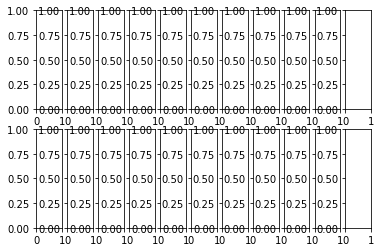

In [ ]:
#--------------------------------------------------
# Extracting heatmap
#--------------------------------------------------
print('********** Extracting heatmap **********')


def getCAM(feature_conv, weight):
    _, nc, h, w = feature_conv.shape
    cam = weight.dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam_img = cam / (np.max(cam) +1e-3)
    return [cam_img]

def getForwardCAM(feature_conv):
    cam = feature_conv.sum(axis =0).sum(axis =0)
    cam = cam - np.min(cam)
    cam_img = cam / (np.max(cam) +1e-3)
    return [cam_img]

#initializes empty self-parameters for new image
def cleanup_model(model):
    model.module.saved_grad = 0
    model.module.saved_forward = []
    model.saved_grad = 0
    model.saved_forward = []

    model.module.gradients = []
    model.module.activations = []
    model.module.fc2_outputs = []

    model.module.hook_dict.clear()
    model.module.hook_dict_2.clear()


klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

cam_dict = {}
ann_dict = {}
show_flag = True


model.eval()


fig, axes = plt.subplots(len(img_nums)+1, 10+1)
gs1 = gridspec.GridSpec(len(img_nums)+1, 10+1)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes.


**SNN-crafted GradCAM**

iteration 0/1


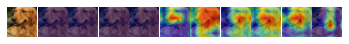

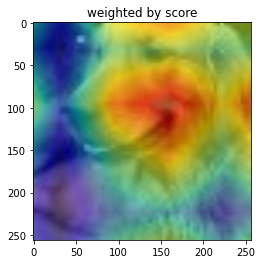

no lim


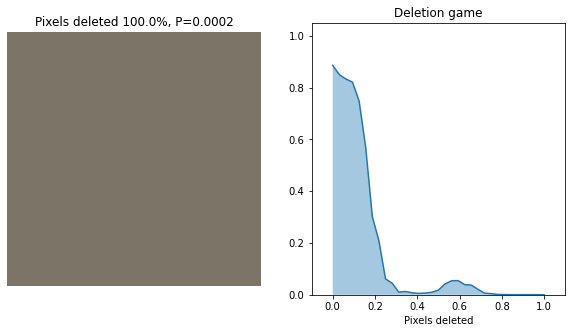

0.1630691486343494
no lim


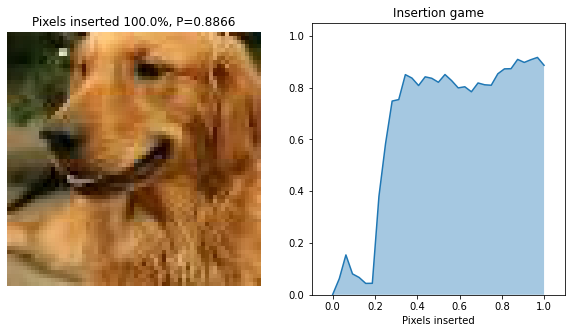

0.6592773785450845
average pixel wise variance of target layer 8: 0.06141136586666107


In [ ]:
from ast import arg
img_idx = 0


import cv2
from numpy.core.fromnumeric import argmax

show_flag = True

heatmaps_max = []
heatmaps_mean = []
heatmaps_weigted = []

insertion = CausalMetric(model, 'ins', 64*2, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 64*2, substrate_fn=torch.zeros_like)

target_layer=8

total_var = 0
for j, (data, data_disp) in enumerate(zip(testloader, display_loader)):
    
    #if j < 5000:
    #    continue  

    if j > 4999:    
        break  

    if show_flag is True:
       
        if j not in img_nums:
            continue
        if j > np.max(img_nums):
            exit()

    if j % 100 == 0:
        print ('iteration {}/{}'.format(j, len(testloader)))

    
    model.zero_grad()
    
    #initializes empty self-parameters for new image
    cleanup_model(model)


    images_disp, labels_disp  = data_disp
    images, labels_cpu = data
    images = images.cuda()
    labels = labels_cpu.cuda()


    images.requires_grad=True

    output_list  = model(images, target_layer=target_layer)
    
    if show_flag is True:
        axes[img_idx, 0] = plt.subplot(gs1[img_idx, 0])
        axes[img_idx, 0].axis('off')
        axes[img_idx, 0].imshow(images_disp[0, ...].permute(1, 2, 0))
    

    #index of predidcted class
    argmax_pred  = output_list.argmax(dim=1)
   
    #get the gradient of the output with respect to the parameters of the model (for all timesteps)
    output_list[:, argmax_pred.item()].backward(retain_graph=True)
    
    #get the activations of the target convolutional layer
    activs = model.module.activations
   
    #get the fc2 layer output for all timesteps
    fc2_outputs = torch.stack(model.module.fc2_outputs)

    #we only need the scores of the target class
    fc2_outputs_indexed = torch.index_select(fc2_outputs,2,argmax_pred).squeeze()

    #pull the gradients of the model (returns a dict with timesteps as keys and with the gradients as values)
    grads = model.module.hook_dict_2
    

    process = 0
    time = 0

    heatmap_list = []

    if 0 not in grads.keys():
        grads[0] = torch.zeros(activs[0].shape).cuda()   

    #for all t
    for i in range(len(activs)):
                
        if i+1 not in grads.keys():
          grads[i+1] = torch.zeros(activs[0].shape).cuda()

        #get gradients from t_0 to t_i        
        sliced_grads = [grads[key] for key in range(i+1)]
        
        #accumulate the gradients from t_0 to t_i
        accumalated_grads = torch.stack(sliced_grads, dim=0).sum(dim=0)
    
        #pool the accumulated gradients
        pooled_gradients = torch.mean(accumalated_grads, dim=[0, 2, 3])
        

        #weighted sum using CAM function
        overlay = getCAM(activs[i].cpu().detach().numpy(), pooled_gradients.cpu().detach().numpy())
        
        overlay = overlay[0]
    
        if show_flag is True:
            if process%3 == 0:
                axes[img_idx, process//3+1 ] = plt.subplot(gs1[img_idx, process//3+1 ])
                axes[img_idx, process//3+1 ].axis('off')
                axes[img_idx, process//3+1].imshow(images_disp[0, ...].permute(1, 2, 0))
                axes[img_idx, process//3+1 ].imshow(
                    skimage.transform.resize(overlay, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
        
        process += 1
        time += 1
        heatmap_list.append(overlay)
        



    for hook in model.module.hook_dict.items():
        hook[1].remove()



    stacked_heatmaps = np.stack(heatmap_list)
    
    #max merge
    max_merged_heatmap = stacked_heatmaps.max(0)
    
    #mean merge
    mean_merged_heatmap = stacked_heatmaps.mean(0)
    
    #weighted merge 
    weight = fc2_outputs_indexed.cpu().detach().numpy()


    nc, h, w = stacked_heatmaps.shape
    weighted_merged_heatmap = weight.dot(stacked_heatmaps.reshape((nc, h*w)))
    weighted_merged_heatmap = weighted_merged_heatmap.reshape(h, w)
    weighted_merged_heatmap = weighted_merged_heatmap - np.min(weighted_merged_heatmap)
    weighted_merged_heatmap = weighted_merged_heatmap / (np.max(weighted_merged_heatmap) +1e-3)

    figure, axis = plt.subplots(1,1)
    #axis[0].imshow(images_disp[0, ...].permute(1, 2, 0))
    #axis[0].imshow(skimage.transform.resize(max_merged_heatmap, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
    #axis[0].set_title('max')
    
    axis.imshow(images_disp[0, ...].permute(1, 2, 0))
    axis.imshow(skimage.transform.resize(mean_merged_heatmap, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
    axis.set_title('mean')
    
    #axis.imshow(images_disp[0, ...].permute(1, 2, 0))
    #axis.imshow(skimage.transform.resize(weighted_merged_heatmap, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
    #axis.set_title('weighted by score')
    plt.show()

    sal = skimage.transform.resize(mean_merged_heatmap, (64, 64))



    print(auc(deletion.single_run(images.detach().cpu(), sal, verbose=1)))
    print(auc(insertion.single_run(images.detach().cpu(), sal, verbose=1)))
  
    max_of_heatmaps = np.stack(heatmap_list, axis=0).max(axis=0)
    total_var += np.var(max_of_heatmaps)
    
   
    img_idx +=1      
    



    #heatmaps_max.append(skimage.transform.resize(max_merged_heatmap, (64, 64)))
    #heatmaps_mean.append(skimage.transform.resize(mean_merged_heatmap, (64, 64)))
    #heatmaps_weigted.append(skimage.transform.resize(weighted_merged_heatmap, (64, 64)))
    
     
#np.savez('GRAD_Max_last5000.npz', *heatmaps_max)
#np.savez('GRAD_Mean_last5000.npz', *heatmaps_mean)
#np.savez('GRAD_Weighted_first100.npz', *heatmaps_weigted)  

print(f"average pixel wise variance of target layer {target_layer}: {total_var/len(img_nums)}")    

**SAM**

iteration 0/1


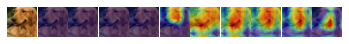

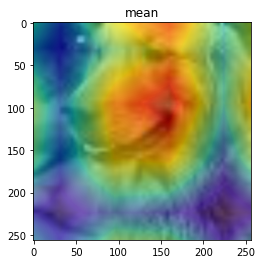

(64, 64)
no lim


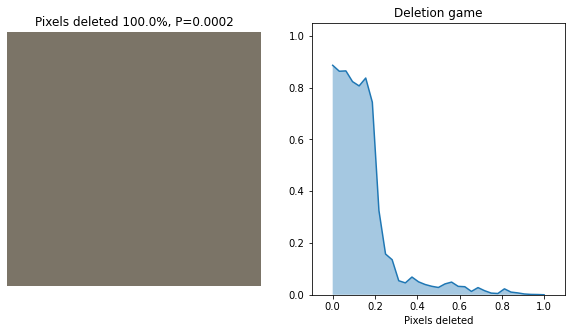

no lim


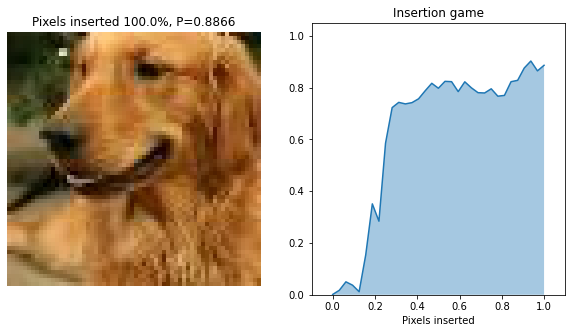

0.20601520860054734
0.633994140131108


<Figure size 432x288 with 0 Axes>

In [ ]:
img_idx = 0
target_layer=8

show_flag = True

heatmaps_max = []
heatmaps_mean = []
heatmaps_weigted = []

insertion = CausalMetric(model, 'ins', 64*2, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 64*2, substrate_fn=torch.zeros_like)

scores = {'del': [], 'ins': []}

for j, (data, data_disp) in enumerate(zip(testloader, display_loader)):
    #if j < 5000:
    #    continue  
    #if j > 4999:
    #      break  

    if show_flag is True:
        #pass
        if j not in img_nums:
            continue
        if j > np.max(img_nums):
            exit()


        

    if j % 100 == 0:
        print ('iteration {}/{}'.format(j, len(testloader)))

    #initializes empty self-parameters for new image
    cleanup_model(model)


    images_disp, labels_disp  = data_disp
    images, labels_cpu = data
    images = images.cuda()
    labels = labels_cpu.cuda()

    output_list  = model(images, target_layer=target_layer)

    if show_flag is True:
        axes[img_idx, 0] = plt.subplot(gs1[img_idx, 0])
        axes[img_idx, 0].axis('off')
        axes[img_idx, 0].imshow(images_disp[0, ...].permute(1, 2, 0))

    process = 0
    time = 0
    cam_save = 0
    overlay_list = []
    previous_spike_time_list = []
    activation_list_value = (model.module.saved_forward)

    #index of predidcted class
    argmax_pred  = output_list.argmax(dim=1)

    #get the fc2 layer output for all timesteps
    fc2_outputs = torch.stack(model.module.fc2_outputs)

    #we only need the scores of the target class
    fc2_outputs_indexed = torch.index_select(fc2_outputs,2,argmax_pred).squeeze()

    for l, activation in enumerate(activation_list_value):
        activation = activation
        previous_spike_time_list.append(activation)
        weight = 0

        for prev_t in range(len(previous_spike_time_list)):
            delta_t = time - previous_spike_time_list[prev_t]* prev_t
            weight +=  torch.exp(gamma * (-1) * delta_t)
        
        weighted_activation = weight.cuda() * activation
        weighted_activation = weighted_activation.data.cpu().numpy()
        
      
        overlay = getForwardCAM(weighted_activation)
        overlay_list.append(overlay[0])

        if show_flag is True:
            if process%3 == 0:
                axes[img_idx, process//3+1 ] = plt.subplot(gs1[img_idx, process//3+1 ])
                axes[img_idx, process//3+1 ].axis('off')
                axes[img_idx, process//3+1].imshow(images_disp[0, ...].permute(1, 2, 0))
                axes[img_idx, process//3+1 ].imshow(
                    skimage.transform.resize(overlay[0], (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')

        process += 1
        time += 1

    cam_dict[j] = overlay_list
    img_idx +=1

    

    stacked_heatmaps = np.stack(overlay_list)
    
    #max merge
    max_merged_heatmap = stacked_heatmaps.max(0)
    
    #mean merge
    mean_merged_heatmap = stacked_heatmaps.mean(0)
    
    #weighted merge 
    weight = fc2_outputs_indexed.cpu().detach().numpy()


    nc, h, w = stacked_heatmaps.shape
   
    weighted_merged_heatmap = weight.dot(stacked_heatmaps.reshape((nc, h*w)))
    weighted_merged_heatmap = weighted_merged_heatmap.reshape(h, w)
    weighted_merged_heatmap = weighted_merged_heatmap - np.min(weighted_merged_heatmap)
    weighted_merged_heatmap = weighted_merged_heatmap / (np.max(weighted_merged_heatmap) +1e-3)

    figure, axis = plt.subplots(1,1)

    #axis[0].imshow(images_disp[0, ...].permute(1, 2, 0))
    #axis[0].imshow(skimage.transform.resize(max_merged_heatmap, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
    #axis[0].set_title('max')
    
    axis.imshow(images_disp[0, ...].permute(1, 2, 0))
    axis.imshow(skimage.transform.resize(mean_merged_heatmap, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
    axis.set_title('mean')
    
    #axis.imshow(images_disp[0, ...].permute(1, 2, 0))
    #axis.imshow(skimage.transform.resize(weighted_merged_heatmap, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
    #axis.set_title('weighted by score')
    plt.show()
    
    sal = skimage.transform.resize(mean_merged_heatmap, (64, 64))
    print(sal.shape)



    ins_score = auc(deletion.single_run(images.detach().cpu(), sal, verbose=1))
    del_score = auc(insertion.single_run(images.detach().cpu(), sal, verbose=1))

    print(ins_score)
    print(del_score)

    #scores['del'].append(ins_score)
    #scores['ins'].append(del_score)

    #heatmaps_max.append(skimage.transform.resize(max_merged_heatmap, (64, 64)))
    #heatmaps_mean.append(skimage.transform.resize(mean_merged_heatmap, (64, 64)))
    #heatmaps_weigted.append(skimage.transform.resize(weighted_merged_heatmap, (64, 64)))

     
#print('----------------------------------------------------------------')
#print('Final:\nDeletion - {:.5f}\nInsertion - {:.5f}'.format(np.mean(scores['del']), np.mean(scores['ins'])))

#np.savez('SAM_Max_last5000.npz', *heatmaps_max)
#np.savez('SAM_Mean_last5000.npz', *heatmaps_mean)
#np.savez('SAM_Weighted_first100.npz', *heatmaps_weigted)

if show_flag is True:
    if os.path.isdir('figuresave') is not True:
        os.mkdir('figuresave')
    plt.savefig(os.path.join('figuresave', 'actmap_ly'+str(target_layer)+'.png' ), dpi=600)




**SNN Score-CAM**

iteration 0/1


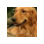

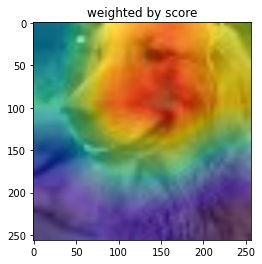

no lim


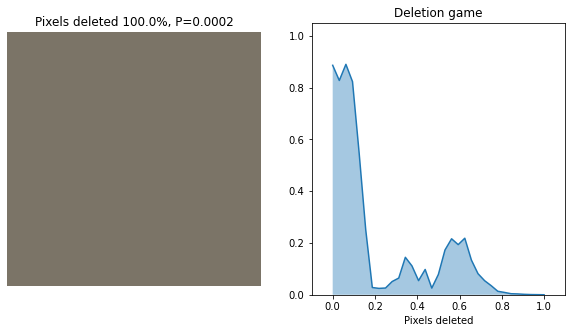

no lim


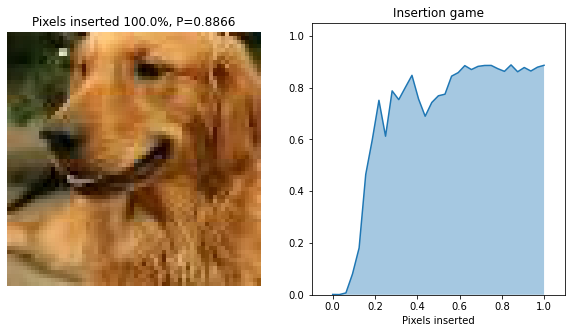

0.1760971423564115
0.6965010371877725
----------------------------------------------------------------
average pixel wise variance of target layer 8: 0.0


In [ ]:
from ast import arg
img_idx = 0

#from torchviz import make_dot
import cv2
from numpy.core.fromnumeric import argmax

target_layer=8

show_flag = True

heatmaps_max = []
heatmaps_mean = []
heatmaps_weigted = []

insertion = CausalMetric(model, 'ins', 64*2, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 64*2, substrate_fn=torch.zeros_like)

total_var = 0
for j, (data, data_disp) in enumerate(zip(testloader, display_loader)):
    #if j < 5000:
    #    continue  
    #if j > 4999:
    #      break  

    if show_flag is True:
        if j not in img_nums:
            continue
        if j > np.max(img_nums):
            exit()

    if j % 10 == 0:
        print ('iteration {}/{}'.format(j, len(testloader)))

    model.zero_grad()

    #initializes empty self-parameters for new image
    cleanup_model(model)

    images_disp, labels_disp  = data_disp
    images, labels_cpu = data
    images = images.cuda()
    labels = labels_cpu.cuda()

    images.requires_grad=True

    output_list  = model(images, target_layer=target_layer)
    
    if show_flag is True:
        axes[img_idx, 0] = plt.subplot(gs1[img_idx, 0])
        axes[img_idx, 0].axis('off')
        axes[img_idx, 0].imshow(images_disp[0, ...].permute(1, 2, 0))
    

    #index of predidcted class
    argmax_pred  = output_list.argmax(dim=1)
       
    #get the activations of the target convolutional layer
    activs = model.module.activations

    #get the fc2 layer output for all timesteps
    fc2_outputs = torch.stack(model.module.fc2_outputs)

    #we only need the scores of the target class
    fc2_outputs_indexed = torch.index_select(fc2_outputs,2,argmax_pred).squeeze()

    #get the weights (the fully connected layer outputs for every timestep)
    weight = fc2_outputs_indexed.cpu().detach().numpy()
    

    activs_stacked = torch.stack(activs).squeeze().cpu().detach().numpy()

    #max merge
    #merged_heatmap = np.max(activs_stacked, 0)
    
    #mean merge
    merged_heatmap = np.mean(activs_stacked, 0)
    
    #weight merge
    #t,nc, h, w = activs_stacked.shape
    #weighted_merge_heatmap = weight.dot(activs_stacked.reshape((t,nc*h*w)))
    #merged_heatmap = weighted_merge_heatmap.reshape(nc, h, w)

    
    activs_merged = torch.from_numpy(merged_heatmap).cuda().unsqueeze(0)
    

    score_saliency_map = torch.zeros((1, 1, 64, 64)).cuda()

    img_tensor_list = []    
    upsampeled_map_list = []

    for i in range(activs_merged.shape[1]):
        
        #upsample
        
        upsampeled_map = activs_merged[:,i,:,:].unsqueeze(0).detach()
        upsampeled_map= F.interpolate(upsampeled_map, size=(64, 64), mode='bilinear', align_corners=False)

        upsampeled_map_list.append(upsampeled_map)

        norm_upsampeled_map = (upsampeled_map - upsampeled_map.min()) / (upsampeled_map.max() - upsampeled_map.min())



        img_tensor = images*norm_upsampeled_map
        img_tensor_list.append(img_tensor)

    
    upsampeled_map_stack = torch.stack(upsampeled_map_list).squeeze()
    
    #split img_tensor_list into chunks, 512 forward passes will take some time, splitting in chunks increases efficiency a bit
    #chunk_size = 30, larger chunk size will crash notebook
    chunks = [img_tensor_list[x:x+20] for x in range(0, len(img_tensor_list), 20)]


    chunk_outputs = []
    #without chunks, per single image takes around 1:30 minutes for all the 512 maps
    #with chunks around 10 seconds for all the 512 maps
    for chunk in chunks:

      img_tensor_stacked = torch.stack(chunk).squeeze()

      #initializes empty self-parameters for new image
      cleanup_model(model)

      output_list  = model(img_tensor_stacked, target_layer=target_layer)
      
      
      chunk_outputs.append(output_list.detach())
      
    #concatenate chunks to get all the scores
    concatenated_chunks = torch.cat(chunk_outputs, dim=0)
    concatenated_chunks  = F.softmax(concatenated_chunks,dim=1)
    
    #get only scores of target class
    scores = concatenated_chunks[:, argmax_pred]
    
    scores = scores.squeeze().cpu().detach().numpy()
    upsampeled_map_stack = upsampeled_map_stack.cpu().detach().numpy()
    
    #weighted sum of scores with upsamepeled maps
    nc, h, w = upsampeled_map_stack.shape
    score_saliency_map = scores.dot(upsampeled_map_stack.reshape((nc,h*w)))
    score_saliency_map = score_saliency_map.reshape(h, w) 
    
    score_saliency_map = F.relu(torch.from_numpy(score_saliency_map))
    score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

    score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data
    

    score_saliency_map = score_saliency_map.squeeze().cpu()

    figure, axis = plt.subplots(1,1)
    axis.imshow(images_disp[0, ...].permute(1, 2, 0))
    axis.imshow(skimage.transform.resize(score_saliency_map, (visual_imagesize, visual_imagesize)), alpha=0.5, cmap='jet')
    axis.set_title('weighted by score')
    plt.show()

    sal = skimage.transform.resize(score_saliency_map, (64, 64))



    ins_score = auc(deletion.single_run(images.detach().cpu(), sal, verbose=1))
    del_score = auc(insertion.single_run(images.detach().cpu(), sal, verbose=1))

    print(ins_score)
    print(del_score) 
    

    for hook in model.module.hook_dict.items():
        hook[1].remove()  
    
    #heatmaps_max.append(skimage.transform.resize(score_saliency_map, (64, 64)))
    #heatmaps_mean.append(skimage.transform.resize(score_saliency_map, (64, 64)))
    #heatmaps_weigted.append(skimage.transform.resize(score_saliency_map, (64, 64)))

     
print('----------------------------------------------------------------')
#print('Final:\nDeletion - {:.5f}\nInsertion - {:.5f}'.format(np.mean(scores['del']), np.mean(scores['ins'])))
#np.savez('SCORE_Max_last5000.npz', *heatmaps_max)
#np.savez('SCORE_Mean_last5000.npz', *heatmaps_mean)
#np.savez('SCORE_Weighted_first100.npz', *heatmaps_weigted)
    
    
    
print(f"average pixel wise variance of target layer {target_layer}: {total_var/len(img_nums)}")    

**Insertion/Deletion Evaluation**

In [ ]:
model.eval()

insertion = CausalMetric(model, 'ins', 40, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 40, substrate_fn=torch.zeros_like)

scores = {'del': [], 'ins': []}



#2 x 5000 heatmaps
method = "SCORE"
merge = "Weighted"

num_images = 5000

for i in range(2):
    data_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(dataset_path, transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])),
    batch_size=1, shuffle=False)

    
    images = np.empty((num_images, 1, 3, 64, 64))

    
    for j, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Loading images')):
        
        if j >= i*num_images  and  j < num_images * (i + 1):
            
            images[j-i*num_images] = img
        
        
    images = images.reshape((-1, 3, 64, 64))

    
    # Load saved batch of explanations
    if i == 0:
        container = np.load(str(method) + '_' + str(merge) + '_first5000.npz')
    else:
        container = np.load(str(method) + '_' + str(merge) + '_last5000.npz')
    
    data = [container[key] for key in container]
   
  
    exp = np.stack(data)


    # Evaluate deletion
    h = deletion.evaluate(torch.from_numpy(images.astype('float32')), exp, 25)
    scores['del'].append(auc(h.mean(1)))

    
    
    # Evaluate insertion
    h = insertion.evaluate(torch.from_numpy(images.astype('float32')), exp, 25)
    scores['ins'].append(auc(h.mean(1)))

    

print('----------------------------------------------------------------')
print('Final:\nDeletion - {:.5f}\nInsertion - {:.5f}'.format(np.mean(scores['del']), np.mean(scores['ins'])))